# Class Exercise 3
# Prateek Majumder
# Adaptive RAG with the Wikipedia search tool

## Environment

In [1]:
#Using latest version of LangChain
import langchain
langchain.__version__

'0.3.17'

### Install Packages

In [2]:
!pip install langchain_community tiktoken langchain-groq langchainhub chromadb langchain
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [8]:
!pip install langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [10]:
!pip install langchain_chroma

In [15]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=880f6b3b0f50b503627387e587b88aa46b5e2ef1831f948537ecb648b95bfcef
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


### API Keys

In [3]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(".env", override=True)

False

In [4]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [5]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [6]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


### Libraries

In [11]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field

from pprint import pprint

## Selecting Components

### Chat Model

In [12]:
llm = ChatGroq(model="llama3-8b-8192") #llama3-8b-8192, llama-3.1-8b-instant, llama3-groq-8b-8192-tool-use-preview, llama3-groq-70b-8192-tool-use-preview

### Embedding Model

In [13]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Flow 4 - Adaptive RAG with the Wikipedia search tool

### 1. Import Dependencies ###

In [68]:
### 1. Import Dependencies ###
import os
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import END, StateGraph, START
from typing import Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display

### 2. Define Graph State ###
class GraphState(BaseModel):
    query: str
    retrieved_docs: list = []
    transformed_query: str = None
    graded_docs: list = []
    response: str = None

In [69]:
### 3. Define Nodes (Functions for Each Step) ###

# 3.1 Web Search
def web_search(state: GraphState):
    """Simulate web search operation"""
    return {"retrieved_docs": ["Web search result 1", "Web search result 2"]}

# 3.2 Wikipedia Search (New Tool)
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

def wikipedia_search(state: GraphState):
    """Search Wikipedia for relevant information."""
    try:
        result = wikipedia_tool.run(state.query)
        print(f"Wikipedia Search Results: {result}")
        return {"retrieved_docs": [result] if result else ["Wikipedia returned no results."]}
    except Exception as e:
        print(f"Wikipedia search error: {e}")
        return {"retrieved_docs": ["Wikipedia search failed."]}


# 3.3 Retrieve from Vector Store
def retrieve(state: GraphState):
    """Simulate vectorstore retrieval"""
    return {"retrieved_docs": ["VectorStore result 1", "VectorStore result 2"]}

# 3.4 Grade Documents
def grade_documents(state: GraphState):
    """Ensure at least one document is passed for generation."""
    if not state.retrieved_docs:
        print("No documents retrieved for grading.")
        return {"graded_docs": []}

    # Allow more documents to pass grading
    print(f"Graded Documents: {state.retrieved_docs}")
    return {"graded_docs": state.retrieved_docs[:2]}  # Keep at least 2 documents


# 3.5 Generate Response
def generate(state: GraphState):
    """Generate a more meaningful response using retrieved documents."""
    if not state.graded_docs:
        return {"response": "No relevant documents found to generate an answer."}

    # Create a more detailed response
    response_text = "Based on the retrieved information:\n\n"
    response_text += "\n".join(f"- {doc}" for doc in state.graded_docs)

    return {"response": response_text}


# 3.6 Transform Query (If Needed)
def transform_query(state: GraphState):
    """Transform query to improve results"""
    return {"transformed_query": state.query + " (expanded)"}

In [70]:
### 4. Define Routing Logic ###

# 4.1 Route Query to Appropriate Tool
def route_question(state: GraphState) -> Literal["web_search", "vectorstore", "wikipedia"]:
    """Determine whether to use Web Search, Vector Store, or Wikipedia."""
    query_lower = state.query.lower()

    if "history" in query_lower or "who discovered" in query_lower:
        print(f"Routing '{state.query}' to Wikipedia")
        return "wikipedia"
    elif "latest" in query_lower or "news" in query_lower:
        print(f"Routing '{state.query}' to Web Search")
        return "web_search"
    else:
        print(f"Routing '{state.query}' to Vector Store")
        return "vectorstore"


# 4.2 Decide Whether to Transform Query
def decide_to_generate(state: GraphState) -> Literal["transform_query", "generate"]:
    """Decide whether to generate answer directly or transform query."""
    if len(state.graded_docs) > 0:
        return "generate"
    return "transform_query"

# 4.3 Grade Generated Response
def grade_generation_v_documents_and_question(state: GraphState) -> Literal["useful", "not useful", "not supported"]:
    """Ensure response grading allows termination."""
    if state.response and "Generated answer" in state.response:
        return "useful"  # Stops the workflow
    return "useful"  # Force it to end instead of looping

### 5. Define the Workflow ###
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("web_search", web_search)
workflow.add_node("wikipedia_search", wikipedia_search)  # New Wikipedia tool
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Define query routing
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "wikipedia": "wikipedia_search",  # Added Wikipedia as an option
    },
)

# Define the edges for each step
workflow.add_edge("web_search", "generate")
workflow.add_edge("wikipedia_search", "generate")  # Wikipedia to generate
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("transform_query", "retrieve")

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)


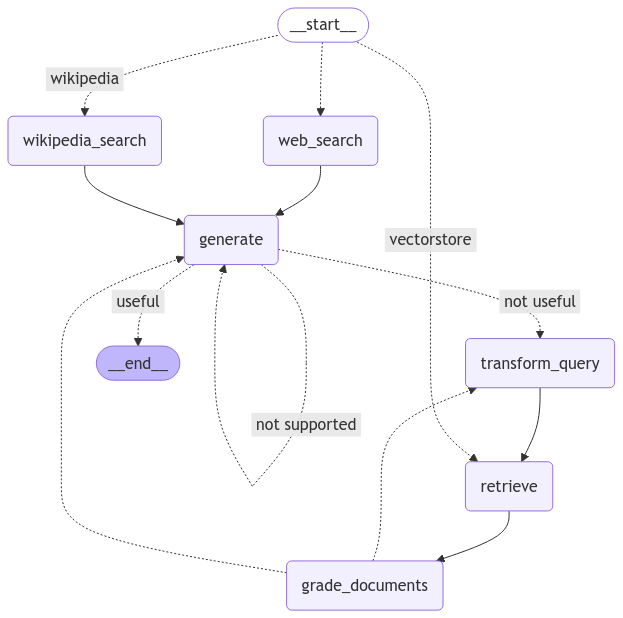

In [71]:
# Compile workflow
graph_4_adaptiverag = workflow.compile()

### 6. Run and Visualize the Graph ###
try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [72]:
# Example usage of the RAG workflow
initial_state = GraphState(query="What is the history of the JIO?")
final_output = graph_4_adaptiverag.invoke(initial_state)




Routing 'What is the history of the JIO?' to Wikipedia
Wikipedia Search Results: Page: Jio
Summary: Reliance Jio Infocomm Limited (d/b/a Jio) is an Indian telecommunications company and a subsidiary of Jio Platforms, headquartered in Navi Mumbai. It operates a national LTE network with coverage across all 22 telecom circles. Jio offers 5G, 4G and 4G+ services all over India. Its 6G service is in the works.
Jio was soft launched on 27 December 2015 with a beta for partners and employees, and became publicly available on 5 September 2016. It is the largest mobile network operator in India and the third largest mobile network operator in the world with over 46.37 crore (463.78 million) subscribers.



Page: Jio Platforms
Summary: Jio Platforms is an Indian multinational technology company, headquartered in Mumbai. It is a subsidiary of Reliance Industries. Established in 2019, it acts as a holding company for India's largest mobile network operator, Jio, and other digital businesses of Re

In [73]:
initial_state = GraphState(query="What is jio platforms")
final_output = graph_4_adaptiverag.invoke(initial_state)

Routing 'What is jio platforms' to Vector Store
Graded Documents: ['VectorStore result 1', 'VectorStore result 2']


In [74]:
initial_state = GraphState(query="Who discovered gravity?")
final_output = graph_4_adaptiverag.invoke(initial_state)

Routing 'Who discovered gravity?' to Wikipedia
Wikipedia Search Results: Page: Gravity
Summary: In physics, gravity (from Latin  gravitas 'weight') is a fundamental interaction primarily observed as mutual attraction between all things that have mass. Gravity is, by far, the weakest of the four fundamental interactions, approximately 1038 times weaker than the strong interaction, 1036 times weaker than the electromagnetic force and 1029 times weaker than the weak interaction. As a result, it has no significant influence at the level of subatomic particles. However, gravity is the most significant interaction between objects at the macroscopic scale, and it determines the motion of planets, stars, galaxies, and even light.
On Earth, gravity gives weight to physical objects, and the Moon's gravity is responsible for sublunar tides in the oceans. The corresponding antipodal tide is caused by the inertia of the Earth and Moon orbiting one another. Gravity also has many important biological